In [1]:
#x01_populationStatistics

In [2]:
from chewc.callback import *
from chewc.policy import *
from chewc.sim import *
from chewc.lab import *
from chewc.config import *

In [3]:
import matplotlib.pyplot as plt
import uuid
import pdb
import torch
from matplotlib.animation import FuncAnimation
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import gymnasium as gym
import numpy as np
device='cpu'
from torch.utils.tensorboard import SummaryWriter



import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList


In [4]:
config = get_default_config()
config['n_parents'] = 2
config['n_loci'] = 50
config['pop_size'] = 100
config['max_generations'] = 4
config['total_timesteps'] = 400000
config['seed'] = 6
for i in config:
    print(f"{i} : {config[i]}")
env = create_simulation(config)
env.reset()

action_low : 0.05
action_high : 0.95
sparse_reward : False
n_parents : 2
n_chr : 1
n_loci : 50
pop_size : 100
max_generations : 4
h2 : 0.5
target_mean : 0
target_variance : 1
reps : 1
total_timesteps : 400000
learning_rate : 0.0003
gae_lambda : 0.95
log_freq : 100
start_gen : 10
end_gen : 100
start_gae_lambda : 0.9
end_gae_lambda : 0.95
seed : 6


({'population': array([[[[0, 0, 0, ..., 0, 0, 0]],
  
          [[0, 0, 0, ..., 0, 1, 0]]],
  
  
         [[[0, 1, 1, ..., 0, 1, 1]],
  
          [[0, 1, 1, ..., 0, 1, 1]]],
  
  
         [[[0, 1, 1, ..., 0, 1, 1]],
  
          [[0, 1, 1, ..., 0, 1, 1]]],
  
  
         ...,
  
  
         [[[0, 0, 0, ..., 0, 0, 0]],
  
          [[0, 0, 1, ..., 0, 1, 1]]],
  
  
         [[[0, 0, 0, ..., 0, 1, 0]],
  
          [[0, 0, 0, ..., 0, 0, 0]]],
  
  
         [[[0, 0, 0, ..., 0, 0, 0]],
  
          [[0, 1, 1, ..., 0, 1, 0]]]], dtype=int32),
  'generation': array([0.], dtype=float32)},
 {'max_phenotype': 2.7528321743011475,
  'genetic_variance': 0.9999999403953552,
  'current_generation': 0})

(array([ 2.,  1.,  7., 13., 13., 29., 13., 14.,  4.,  4.]),
 array([-2.44620132, -1.92629802, -1.4063946 , -0.8864913 , -0.36658794,
         0.15331542,  0.67321879,  1.19312215,  1.71302545,  2.23292875,
         2.75283217]),
 <BarContainer object of 10 artists>)

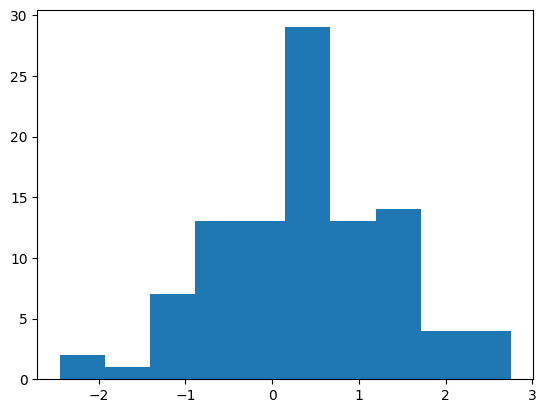

In [5]:
plt.hist(env.population.breeding_values)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def collect_baselines(env, actions, repetitions=10, cycles=5):
    results = {action: {'max_phenotype': [], 'gv': []} for action in actions}
    final_gen_averages = {}
    env.reset()
    for action in actions:
        final_gen_phenotypes = []
        for _ in range(repetitions):
            env.reset()
            cycle_max_phenotype = []
            cycle_gv = []
            cycle_max_phenotype.append(env.population.breeding_values.max())
            cycle_gv.append(env.population.breeding_values.var())
            for _ in range(cycles):
                env.step(np.array([action]))
                max_phenotype = env.population.breeding_values.max()
                gv = env.population.breeding_values.var()
                cycle_max_phenotype.append(max_phenotype)
                cycle_gv.append(gv)
            
            results[action]['max_phenotype'].append(cycle_max_phenotype)
            results[action]['gv'].append(cycle_gv)
            final_gen_phenotypes.append(cycle_max_phenotype[-1])
        
        final_gen_averages[action] = np.mean(final_gen_phenotypes)
    
    best_action = max(final_gen_averages, key=final_gen_averages.get)
    best_average = final_gen_averages[best_action]
    
    return results, best_action, best_average

def plot_best_run(results, best_action):
    plt.figure(figsize=(10, 6))
    
    max_phenotypes = np.array(results[best_action]['max_phenotype'])
    mean_values = np.mean(max_phenotypes, axis=0)
    std_values = np.std(max_phenotypes, axis=0)
    cycles = range(len(mean_values))
    
    plt.plot(cycles, mean_values, label=f'Action {best_action:.3f}')
    plt.fill_between(cycles, mean_values - std_values, mean_values + std_values, alpha=0.3)
    
    plt.xlabel('Cycle')
    plt.ylabel('Max Phenotype')
    plt.title(f'Max Phenotype over Cycles for Best Action')
    plt.legend()
    plt.grid(True)
    plt.show()



In [7]:
env.SP.max_generations

4

Best action: -0.778
Best average max phenotype in final generation: 7.236


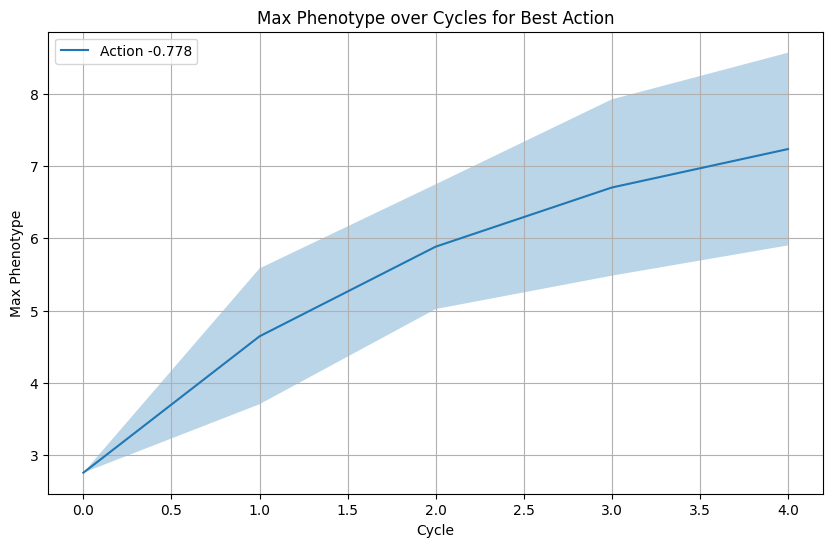

In [8]:
# Usage
actions = np.linspace(-1, 0, 10)  # or however many actions you want to test
results, best_action, best_average = collect_baselines(env, actions, repetitions=10, cycles=env.SP.max_generations)

print(f"Best action: {best_action:.3f}")
print(f"Best average max phenotype in final generation: {best_average:.3f}")

# Plot only the best run
plot_best_run(results, best_action)


In [9]:
env.reset()

({'population': array([[[[0, 0, 0, ..., 0, 0, 0]],
  
          [[0, 0, 0, ..., 0, 1, 0]]],
  
  
         [[[0, 1, 1, ..., 0, 1, 1]],
  
          [[0, 1, 1, ..., 0, 1, 1]]],
  
  
         [[[0, 1, 1, ..., 0, 1, 1]],
  
          [[0, 1, 1, ..., 0, 1, 1]]],
  
  
         ...,
  
  
         [[[0, 0, 0, ..., 0, 0, 0]],
  
          [[0, 0, 1, ..., 0, 1, 1]]],
  
  
         [[[0, 0, 0, ..., 0, 1, 0]],
  
          [[0, 0, 0, ..., 0, 0, 0]]],
  
  
         [[[0, 0, 0, ..., 0, 0, 0]],
  
          [[0, 1, 1, ..., 0, 1, 0]]]], dtype=int32),
  'generation': array([0.], dtype=float32)},
 {'max_phenotype': 2.7528321743011475,
  'genetic_variance': 0.9999999403953552,
  'current_generation': 0})

In [10]:

# Create your custom callbacks
genetic_variance_callback = AverageFinalGenerationCallback(log_freq=1000)
action_callback = ActionTrackingCallback(log_freq=1000)

# Combine the callbacks using CallbackList
combined_callbacks = CallbackList([genetic_variance_callback, action_callback])
vec_env = DummyVecEnv([lambda: env])
# Create and train the model with the custom policy
model = PPO(CustomActorCriticPolicy, vec_env, verbose=1, tensorboard_log="./ppotb")
model.learn(total_timesteps=config['total_timesteps'], callback=combined_callbacks)

In [ ]:
config['sparse_reward'] =False
env = create_simulation(config)
env.reset()
# Create your custom callbacks
genetic_variance_callback = AverageFinalGenerationCallback(log_freq=1000)
action_callback = ActionTrackingCallback(log_freq=1000)

# Combine the callbacks using CallbackList
combined_callbacks = CallbackList([genetic_variance_callback, action_callback])
vec_env = DummyVecEnv([lambda: env])
# Create and train the model with the custom policy
model = PPO(CustomActorCriticPolicy, vec_env, verbose=1, tensorboard_log="./ppotb")
model.learn(total_timesteps=config['total_timesteps'], callback=combined_callbacks)